In [1]:
from google.colab import files
uploaded = files.upload()


Saving Archive 2.zip to Archive 2.zip


In [3]:
import zipfile
import os

zip_path = "Archive 2.zip"
extract_dir = "dataset_guantes"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Contenido:", os.listdir(extract_dir))


Contenido: ['guantes', '__MACOSX', 'sin_guantes']


In [4]:
import shutil
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Eliminar basura macOS
macosx_path = os.path.join(extract_dir, "__MACOSX")
if os.path.exists(macosx_path):
    shutil.rmtree(macosx_path)

# Transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset
dataset = datasets.ImageFolder(root=extract_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Clases:", dataset.classes)
print(f"Total imágenes: {len(dataset)} (train: {train_size}, val: {val_size})")


Clases: ['guantes', 'sin_guantes']
Total imágenes: 17 (train: 13, val: 4)


In [5]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print("Modelo listo en:", device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 63.0MB/s]


Modelo listo en: cpu


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
num_epochs = 10


In [7]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Época {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")


Época 1/10 | Train Loss: 0.5905 | Acc: 0.7692 | Val Loss: 1.0650 | Acc: 0.2500
Época 2/10 | Train Loss: 0.5176 | Acc: 0.8462 | Val Loss: 1.1618 | Acc: 0.2500
Época 3/10 | Train Loss: 0.4814 | Acc: 0.8462 | Val Loss: 1.1088 | Acc: 0.2500
Época 4/10 | Train Loss: 0.4359 | Acc: 0.8462 | Val Loss: 0.9769 | Acc: 0.2500
Época 5/10 | Train Loss: 0.3859 | Acc: 0.8462 | Val Loss: 0.8283 | Acc: 0.2500
Época 6/10 | Train Loss: 0.3409 | Acc: 0.8462 | Val Loss: 0.6991 | Acc: 0.2500
Época 7/10 | Train Loss: 0.3049 | Acc: 0.8462 | Val Loss: 0.6075 | Acc: 0.5000
Época 8/10 | Train Loss: 0.2752 | Acc: 1.0000 | Val Loss: 0.5536 | Acc: 0.5000
Época 9/10 | Train Loss: 0.2473 | Acc: 1.0000 | Val Loss: 0.5302 | Acc: 0.5000
Época 10/10 | Train Loss: 0.2196 | Acc: 1.0000 | Val Loss: 0.5267 | Acc: 0.5000


In [10]:
# Transformaciones con aumento de datos
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Dataset y DataLoader
dataset = datasets.ImageFolder(root=extract_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Clases:", dataset.classes)
print(f"Total imágenes: {len(dataset)} (train: {train_size}, val: {val_size})")


Clases: ['guantes', 'sin_guantes']
Total imágenes: 17 (train: 13, val: 4)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Desbloquear últimas capas convolucionales (fine-tuning)
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
print("Modelo preparado en:", device)


Modelo preparado en: cpu


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
num_epochs = 30


In [13]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Época {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")


Época 1/30 | Train Loss: 0.8671 | Acc: 0.3077 | Val Loss: 0.5559 | Acc: 0.7500
Época 2/30 | Train Loss: 0.5506 | Acc: 0.5385 | Val Loss: 0.5199 | Acc: 0.7500
Época 3/30 | Train Loss: 0.3052 | Acc: 1.0000 | Val Loss: 0.3545 | Acc: 0.7500
Época 4/30 | Train Loss: 0.0974 | Acc: 1.0000 | Val Loss: 0.3766 | Acc: 0.7500
Época 5/30 | Train Loss: 0.1259 | Acc: 1.0000 | Val Loss: 0.4067 | Acc: 0.7500
Época 6/30 | Train Loss: 0.0580 | Acc: 1.0000 | Val Loss: 0.4012 | Acc: 0.7500
Época 7/30 | Train Loss: 0.0367 | Acc: 1.0000 | Val Loss: 0.3241 | Acc: 0.7500
Época 8/30 | Train Loss: 0.0266 | Acc: 1.0000 | Val Loss: 0.4376 | Acc: 0.5000
Época 9/30 | Train Loss: 0.0125 | Acc: 1.0000 | Val Loss: 0.2620 | Acc: 1.0000
Época 10/30 | Train Loss: 0.0087 | Acc: 1.0000 | Val Loss: 0.2618 | Acc: 1.0000
Época 11/30 | Train Loss: 0.0079 | Acc: 1.0000 | Val Loss: 0.3046 | Acc: 0.7500
Época 12/30 | Train Loss: 0.0069 | Acc: 1.0000 | Val Loss: 0.2711 | Acc: 0.7500
Época 13/30 | Train Loss: 0.0053 | Acc: 1.0000 | 

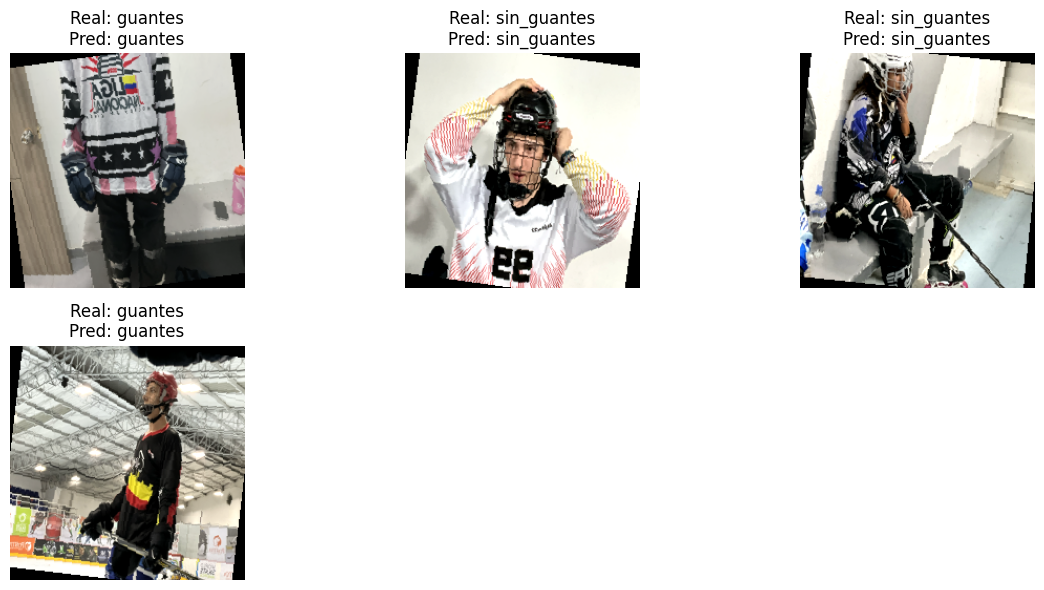

In [14]:
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5
    return np.clip(img, 0, 1)

model.eval()
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

num_imgs = min(6, len(images))  # prevenir IndexError
fig = plt.figure(figsize=(12, 6))
for idx in range(num_imgs):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.imshow(imshow(images[idx].cpu()))
    ax.set_title(f"Real: {dataset.classes[labels[idx]]}\nPred: {dataset.classes[preds[idx]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [15]:
torch.save(model.state_dict(), "modelo_guantes.pth")
files.download("modelo_guantes.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>